# For training classifiers to predict/rank answers
---

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

## Utility functions

In [2]:
import arff
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#import data
def importData(path):
    dataset = arff.load(open(path, 'rb'))
    data = np.array(dataset['data'])
    #print data[:10]

    #extract features and labels
    features = []
    labels = []
    for d in data:
        f = []
        for i in range(len(d) - 1):
            num = float(d[i])
            if int(num) == num:
                num = int(num)
            f.append(num)
        features.append(f)

        if d[-1] == "positive":
            labels.append(1)
        else:
            labels.append(0)
    return np.asarray(features), np.asarray(labels)

In [3]:
def load_similarity_features(filepath):
    features = []
    labels = []
    map_label = {"positive": 1, "negative": 0}
    with open(filepath) as infile:
        for line in infile:
            label, score = line.strip().split(',')
            score = float(score)
            label = map_label[label]
            features.append(score)
            labels.append(label)
            
    return np.asarray(features).reshape(-1, 1), np.asarray(labels)
        

# Prepare data

### Jacana features

In [4]:
#import training data and test data
train_datapath = "../myclassify/qa.train.arff"
test_datapath = "../myclassify/qa.test.arff"

X_train, y_train = importData(train_datapath)
X_test, y_test = importData(test_datapath)

### Add GloVe vectors question answer similarity scores

In [5]:
# Qn answer similarity scores
X_sim_train, y_sim_train = load_similarity_features("../data/features/glove_embedding_sentence_similarities_train_100.txt")
X_sim_test, y_sim_test = load_similarity_features("../data/features/glove_embedding_sentence_similarities_test_100.txt")

X_combined_train = np.hstack((X_train, X_sim_train))
X_combined_test = np.hstack((X_test, X_sim_test))

### Add type features

### Normalize data

NOTE: Might not want to do this for Random Forest-like classifiers

In [5]:
from sklearn.preprocessing import RobustScaler

# Scale combined data
scaler = RobustScaler()
scaler.fit(X_combined_train)
X_comb_scaled_train = scaler.transform(X_combined_train)
X_comb_scaled_test = scaler.transform(X_combined_test)

# Scale Jacana features only
# scaler = RobustScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# Only normalize the similarity scores
scaler = RobustScaler()
scaler.fit(X_sim_train)
X_sim_train = scaler.transform(X_sim_train)
X_sim_test = scaler.transform(X_sim_test)
X_comb_scaledsim_train = np.hstack((X_train, X_sim_train))
X_comb_scaledsim_test = np.hstack((X_test, X_sim_test))

## Apply dim reduction to denoise data

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(X_combined_train)
X_pca_train = pca.transform(X_combined_train)
X_pca_test = pca.transform(X_combined_test)

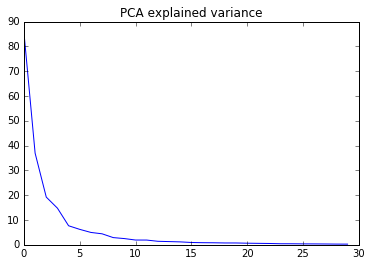

In [10]:
plt.plot(pca.explained_variance_)
plt.title("PCA explained variance")

# Train using Logistic Regression

In [83]:
# Jacana features only
logreg = linear_model.LogisticRegression(C=0.01,
#                                          penalty="l1"
                                        )
logreg = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Compute metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

          0       0.84      0.99      0.91      1233
          1       0.82      0.17      0.28       284

avg / total       0.83      0.84      0.79      1517

[[1222   11]
 [ 235   49]]
Accuracy: 0.837837837838


In [91]:
#logistic regression with qn similarity features

# Jacana + similarity features (no scaling)
logreg = linear_model.LogisticRegression(C=0.2,
                                         penalty="l1"
                                        )
logreg = logreg.fit(X_combined_train, y_train)
y_pred = logreg.predict(X_combined_test)

# Compute metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

          0       0.84      0.98      0.91      1233
          1       0.72      0.21      0.32       284

avg / total       0.82      0.84      0.80      1517

[[1210   23]
 [ 225   59]]
Accuracy: 0.836519446276


In [99]:
#logistic regression with qn similarity features
# Jacana + similarity features (scale similarity only)
logreg = linear_model.LogisticRegression(C=2,
                                        )
logreg = logreg.fit(X_comb_scaledsim_train, y_train)
y_pred = logreg.predict(X_comb_scaledsim_test)

# Compute metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

          0       0.84      0.98      0.91      1233
          1       0.72      0.21      0.33       284

avg / total       0.82      0.84      0.80      1517

[[1209   24]
 [ 223   61]]
Accuracy: 0.837178642057


In [16]:
#logistic regression with qn similarity features
# Jacana + similarity + PCA reduced

clf = linear_model.LogisticRegression(C=0.002,
                                        )
clf.fit(X_pca_train, y_train)
y_pred = clf.predict(X_pca_test)

# Compute metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

          0       0.84      0.99      0.91      1233
          1       0.86      0.15      0.26       284

avg / total       0.84      0.84      0.79      1517

[[1226    7]
 [ 241   43]]
Accuracy: 0.836519446276


In [60]:
# Randomized search with cross validation to find best set of params

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"C": [10, 5, 2, 1, 0.5, 0.3, 0.1, 0.05, 0.03, 0.01, 0.005, 0.003, 0.001, 0.0005]}
clf = linear_model.LogisticRegression()

n_iter_search = 10
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=5,
                                   random_state=457319)

start = time()
random_search.fit(X_comb_scaledsim_train, y_train)
y_pred = random_search.predict(X_comb_scaledsim_test)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


# Compute metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

RandomizedSearchCV took 3.07 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.932 (std: 0.006)
Parameters: {'C': 0.01}

Model with rank: 2
Mean validation score: 0.930 (std: 0.014)
Parameters: {'C': 0.1}

Model with rank: 3
Mean validation score: 0.930 (std: 0.016)
Parameters: {'C': 0.5}

             precision    recall  f1-score   support

          0       0.83      0.99      0.90      1233
          1       0.73      0.11      0.20       284

avg / total       0.81      0.83      0.77      1517

[[1221   12]
 [ 252   32]]
Accuracy: 0.825972313777


In [17]:
# Randomized search with cross validation to find best set of params

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"C": [10, 5, 2, 1, 0.5, 0.3, 0.1, 0.05, 0.03, 0.01, 0.005, 0.003, 0.001, 0.0005]}
clf = linear_model.LogisticRegression()

n_iter_search = 10
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=5,
                                   random_state=457319)

start = time()
random_search.fit(X_pca_train, y_train)
y_pred = random_search.predict(X_pca_test)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


# Compute metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

RandomizedSearchCV took 2.61 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.930 (std: 0.012)
Parameters: {'C': 0.1}

Model with rank: 2
Mean validation score: 0.929 (std: 0.011)
Parameters: {'C': 0.01}

Model with rank: 2
Mean validation score: 0.929 (std: 0.011)
Parameters: {'C': 2}

Model with rank: 2
Mean validation score: 0.929 (std: 0.011)
Parameters: {'C': 10}

             precision    recall  f1-score   support

          0       0.83      0.98      0.90      1233
          1       0.66      0.15      0.25       284

avg / total       0.80      0.83      0.78      1517

[[1210   23]
 [ 240   44]]
Accuracy: 0.826631509558


# Train using Random Forest

In [67]:
# Jacana only
clf = RandomForestClassifier(n_estimators=300,
                             max_depth=12,
#                              min_samples_split=4,
                             criterion="entropy",
                             random_state=3471,
                             class_weight="balanced"
                            )
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

          0       0.84      0.98      0.90      1233
          1       0.68      0.18      0.28       284

avg / total       0.81      0.83      0.79      1517

Accuracy score: 0.830586684245


In [283]:
# Jacana with similarity scores features. Both types of features scaled.
clf = RandomForestClassifier(n_estimators=400,
                             max_depth=12,
                             min_samples_split=4,
                             criterion="entropy",
                             random_state=3471,
                             class_weight="balanced_subsample"
                            )
clf = clf.fit(X_combined_train, y_train)
y_pred = clf.predict(X_combined_test)

print(classification_report(y_test, y_pred))
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

          0       0.85      0.97      0.91      1233
          1       0.67      0.24      0.35       284

avg / total       0.81      0.84      0.80      1517

Accuracy score: 0.835860250494


### Use randomized search to find good parameters

In [100]:
# Jacana only
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"max_depth": [8, 12, 16],
              "min_samples_split": [2, 4, 6],
              "criterion": ["gini", "entropy"],
              "min_samples_leaf": [1, 2, 3],
              "n_estimators": [200, 250, 300],
              "class_weight": [None, "balanced", "balanced_subsample"]}

clf = RandomForestClassifier()
n_iter_search = 10
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=5,
                                   random_state=83716)

start = time()
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# Compute metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

RandomizedSearchCV took 131.00 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.929 (std: 0.009)
Parameters: {'min_samples_leaf': 3, 'n_estimators': 200, 'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 16, 'class_weight': 'balanced_subsample'}

Model with rank: 1
Mean validation score: 0.929 (std: 0.002)
Parameters: {'min_samples_leaf': 2, 'n_estimators': 250, 'criterion': 'entropy', 'min_samples_split': 6, 'max_depth': 8, 'class_weight': None}

Model with rank: 3
Mean validation score: 0.928 (std: 0.004)
Parameters: {'min_samples_leaf': 2, 'n_estimators': 200, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 16, 'class_weight': None}

             precision    recall  f1-score   support

          0       0.85      0.97      0.91      1233
          1       0.65      0.26      0.37       284

avg / total       0.81      0.84      0.80      1517

[[1194   39]
 [ 211   73]]
Accuracy: 0.835201054713


In [75]:
# Jacana with similarity scores features. Only similarity scores are scaled.
start = time()
random_search.fit(X_comb_scaledsim_train, y_train)
y_pred = random_search.predict(X_comb_scaledsim_test)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# Compute metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

RandomizedSearchCV took 147.10 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.929 (std: 0.004)
Parameters: {'min_samples_leaf': 2, 'n_estimators': 200, 'criterion': 'gini', 'min_samples_split': 6, 'max_depth': 16, 'class_weight': None}

Model with rank: 2
Mean validation score: 0.927 (std: 0.002)
Parameters: {'min_samples_leaf': 2, 'n_estimators': 200, 'criterion': 'entropy', 'min_samples_split': 6, 'max_depth': 8, 'class_weight': None}

Model with rank: 3
Mean validation score: 0.927 (std: 0.011)
Parameters: {'min_samples_leaf': 3, 'n_estimators': 250, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 16, 'class_weight': 'balanced_subsample'}

             precision    recall  f1-score   support

          0       0.83      0.99      0.90      1233
          1       0.77      0.08      0.15       284

avg / total       0.82      0.82      0.76      1517

[[1226    7]
 [ 260   24]]
Accuracy: 0.823994726434


## Train using GradientBoostingMachine

## Use RF to embed features then train using LR